In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import Data

In [2]:
fnames = ['/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung01_magneticField.txt', '/Users/hkromer/02_PhD/02_Data/08.Microwave.PermanentMagnets/Messung02_magneticField.txt']

In [3]:
dfs = []
for fname in fnames:
    df = pd.read_csv(fname, skiprows=0, delimiter='\t')
    df.iloc[:,1] = df.iloc[:,1] * 1000 # convert to Gauss
    dfs.append(df)


## Plot

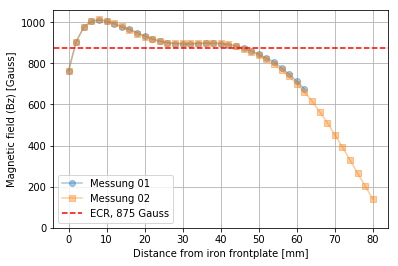

In [19]:
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.4)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.4)
xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

# COMSOL Model
- Iron frontplate is at position 0 mm
- Plasma cup extends into the minus direction
- Data is in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/02.damaged.magneticFieldGrid.csv
    - the data is for X {-100, 10, 1}, Y {-5, 5, 0.2}, Z {-5, 5, 0.2}
    - header: X,Y,Z, mfnc.normB (mT)
- Original simulation is in /Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/02.damaged.mph

In [81]:
fname = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/04.Microwave/02.damaged.magneticFieldGrid.csv'
df_comsol = pd.read_csv(fname, skiprows=8)
df_comsol.columns = ['x', 'y', 'z', 'normB_mT']
df_comsol['normB_Gauss'] = df_comsol['normB_mT'] * 10
print(df_comsol.info())
df_comsol.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288711 entries, 0 to 288710
Data columns (total 5 columns):
x              288711 non-null float64
y              288711 non-null float64
z              288711 non-null float64
normB_mT       288711 non-null float64
normB_Gauss    288711 non-null float64
dtypes: float64(5)
memory usage: 11.0 MB
None


,x,y,z,normB_mT,normB_Gauss
0,-100.0,-5.0,-5.0,24.162996,241.629962
1,-99.0,-5.0,-5.0,23.210859,232.108592
2,-98.0,-5.0,-5.0,22.273074,222.730743
3,-97.0,-5.0,-5.0,21.351533,213.515326
4,-96.0,-5.0,-5.0,20.056738,200.567377


## Treat each y and z value separately
- for each x value find the minimum and maximum B field (depending on the y, z values)
- store in a new column
- plot this around the centerline (y=z=0)

In [82]:
df_comsol = df_comsol.sort_values(by=['x'])
def find_max_Bfield(df):
    mymax = df['normB_Gauss'].max()
    mymin = df['normB_Gauss'].min()
    return pd.Series({'normB_Gauss_max': mymax, 'normB_Gauss_min': mymin})

df_comsol_maxmin = df_comsol.groupby('x').apply(lambda x: find_max_Bfield(x))

In [83]:
df_comsol_maxmin.describe()

,normB_Gauss_max,normB_Gauss_min
count,111.000000,111.000000
mean,695.315641,601.475512
std,429.937382,321.236672
min,116.394143,4.549748
25%,390.846491,289.817222
50%,814.418478,756.780883
75%,870.910922,860.219425
max,3308.209273,986.652316


## Transform

In the measurement the x=0mm is the frontplate, same is for the COMSOL. But in the COMSOL simulation the x goes in - direction, so everything has to be multiplied with -1.

The values at x =0 is not physical

In [84]:
df_comsol_maxmin['x'] = df_comsol_maxmin.index * -1.0
df_comsol_maxmin.set_index('x', inplace=True) 

df_comsol_maxmin.drop([0.0, -1.0], inplace=True)

In [85]:

# df_comsol_maxmin[df_comsol_maxmin['normB_Gauss_max']==df_comsol_maxmin.max().max()]
df_comsol_maxmin.tail(20)

,normB_Gauss_max,normB_Gauss_min
x,,
11.0,974.334013,964.857987
10.0,982.688483,971.354745
9.0,990.876993,977.568430
8.0,997.856086,982.237224
7.0,1005.035475,985.245513
6.0,1010.487596,986.652316
5.0,1015.904626,984.232839
4.0,1020.169095,973.227202
3.0,1024.471110,946.629181


## Plot

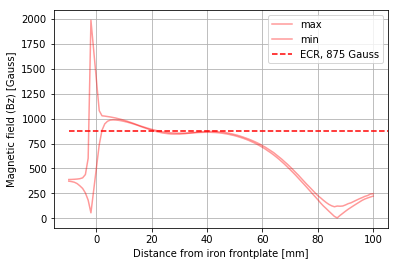

In [86]:
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='red', label='min', alpha=0.4)

xlim = plt.gca().get_xlim()
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')

# plt.ylim(0, ylim[1])
plt.xlim(xlim)
plt.show()

## Experiment and Simulation in comparison

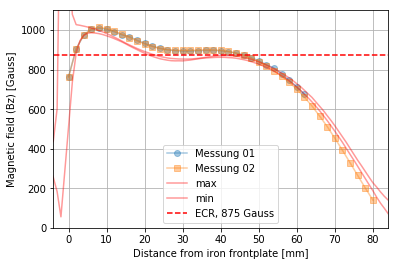

In [91]:
plt.plot(dfs[0].iloc[:,0], dfs[0].iloc[:,1], marker='o',label='Messung 01', alpha=0.4)

plt.plot(dfs[1].iloc[:,0], dfs[1].iloc[:,1], marker='s', label='Messung 02', alpha=0.4)

xlim = plt.gca().get_xlim()
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_max'], color='red', label='max', alpha=0.4)
plt.plot(df_comsol_maxmin.index, df_comsol_maxmin['normB_Gauss_min'], color='red', label='min', alpha=0.4)
plt.plot([-10,200], [875, 875], color='red', linestyle='dashed', label='ECR, 875 Gauss')
plt.legend()
plt.grid()
plt.xlabel('Distance from iron frontplate [mm]')
plt.ylabel('Magnetic field (Bz) [Gauss]')
ylim = plt.gca().get_ylim()
plt.ylim(0, 1100)
plt.xlim(xlim)
plt.show()